In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,29.010676,594.972659,13.273485,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.000000,0.000000,0.268975,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.000000,0.000000,12.048263,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.000000,0.000000,10.140022,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.000000,0.000000,9.102067,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
#dataset.columns.values

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')
dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('bend_gr_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5401, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        todrop.append(index)

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]
dataset.shape

(5358, 665)

# Dataset re-ordering and Splitting

The baseline will be defined with the 3 core factors:
- Thickness
- Area
- Number of bends

In [7]:
#Dataset definition
X = dataset[['thickness', 'minimum_rectangle_area', 'bend_count']]
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

limitedset = ['thickness', 'minimum_rectangle_area', 'bend_count']


# Target definition

In [8]:
target = 'VALTOT'
assert target in y.columns.values, 'The target must be in y dataset'

# Outlier tracking - VAMAT

In [9]:
toplimit = .95 #We drop the top 3%
botlimit = .02 #we drop the bottom 2%

In [10]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
#dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

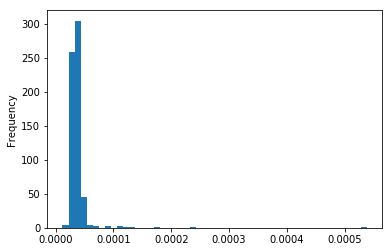

In [11]:
df = dataset[dataset['thickness'] == 5]
df['SURF_COST_RECTANGLE'].plot.hist(bins=50)
plt.show()

In [12]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_RECTANGLE']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_RECTANGLE
thickness                          
2.0       0.02             0.000011
          0.95             0.000026
3.0       0.02             0.000017
          0.95             0.000037
4.0       0.02             0.000020
          0.95             0.000046
5.0       0.02             0.000025
          0.95             0.000049
6.0       0.02             0.000029
          0.95             0.000063
8.0       0.02             0.000041
          0.95             0.000083
10.0      0.02             0.000048
          0.95             0.000122
12.0      0.02             0.000045
          0.95             0.000123
15.0      0.02             0.000059
          0.95             0.000148

In [13]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4982, 666)

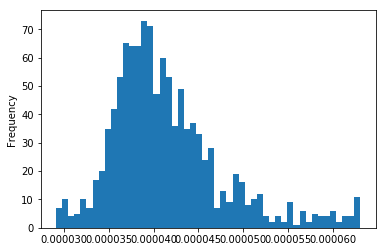

In [14]:
df = dataset[dataset['thickness'] == 6]
df['SURF_COST_RECTANGLE'].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [15]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [16]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

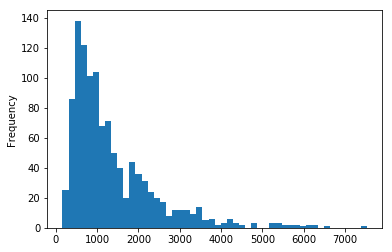

In [17]:
df = dataset[dataset['thickness'] == 6]
df[df.columns.values[0]].plot.hist(bins=50)
plt.show()

In [18]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.705600
                     0.95          7.095500
          1          0.02          0.523400
                     0.95          2.293750
          2          0.02          0.248533
                     0.95          2.147333
          3          0.02          0.623800
                     0.95          1.926500
          4          0.02          0.576240
                     0.95          2.126900
          5          0.02          0.258333
                     0.95          2.060000
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.698875
                     0.95          1.446875
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.217600
                     0.95          6.584000
          1          0.02          0.443200
                     0.95          1.472500
          2          0.02          0.406267
                     0.95          1.838000
          3          0.02          0.358300
                     0.95          2.409500
...                                     ...
10.0      0          0.02          0.593200
                     0.95          8.729000
          1          0.02          0.921600
                     0.95          4.199500
          2          0.02          0.516267
                     0.95          4.018667
          3          0.02          0.991400
                     0.95          3.754500
          4          0.02          1.137600
                     0.95          3.140500
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.807000
          1          0.02          0.225200
                     0.95          2.351000
          2          0.02          0.432000
                     0.95          4.183333
          3          0.02          0.621250
                     0.95          1.167625
          4          0.02          1.814120
                     0.95          1.819700
15.0      0          0.02          0.809800
                     0.95          9.286500
          1          0.02          1.100000
                     0.95          3.058500
          2          0.02          0.853333
                     0.95          7.150000
          3          0.02          0.870000
                     0.95          1.833750

[146 rows x 1 columns]

In [19]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4569, 667)

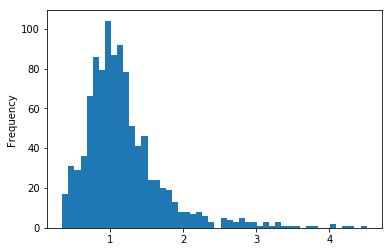

In [20]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

# Target review

In [21]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

In [22]:
y[[target]].describe()

,VALTOT
count,4569.000000
mean,7.634706
std,8.872528
min,0.370000
25%,2.670000
50%,4.710000
75%,9.510000
max,138.970000


In [23]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])
print(X_train.shape, X_test.shape)

(3198, 667) (1371, 667)


# Blocs creation

In [24]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [25]:
# Metric
from sklearn.metrics import mean_squared_error

In [26]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [27]:
#regressions
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, random_state=0, normalize=False, fit_intercept=False)

from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False, fit_intercept=False)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression(normalize=False, fit_intercept=False)

In [28]:
#Other tools
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# No standardisation

In [29]:
parameters = {'alpha':np.logspace(-3,-3,11),
              'l1_ratio':np.linspace(0.001,1,11)
             }
regnostd = GridSearchCV(enet, parameters, cv=5, n_jobs=-2, scoring='neg_mean_squared_error')

In [30]:
regnostd.fit(X_train[limitedset], y_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=0, copy_X=True, fit_intercept=False, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001]), 'l1_ratio': array([0.001 , 0.1009, 0.2008, 0.3007, 0.4006, 0.5005, 0.6004, 0.7003,
       0.8002, 0.9001, 1.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [31]:
regnostd.estimator.l1_ratio

1

In [32]:
regnostd.best_params_

{'alpha': 0.001, 'l1_ratio': 1.0}

In [33]:
regnostd.score(X_train[limitedset], y_train[target])

-17.64087745803289

In [34]:
regnostd.score(X_test[limitedset], y_test[target])

-23.115959819787417

In [35]:
mean_squared_error(y_test[target], regnostd.predict(X_test[limitedset]))

23.115959819787417

In [36]:
regnostd.best_estimator_.coef_

array([ 4.75258901e-01,  4.63761826e-05, -2.24681341e-02])

In [37]:
regnostd.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))

array([10.41478766])

In [38]:
(np.array([10.0, 123061.765625, 2]) * regnostd.best_estimator_.coef_).sum()

10.414787657526995

# VAMAT simplified

In [39]:
df = dataset.groupby('thickness')['SURF_COST_RECTANGLE']
df.agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
thickness,,,,,
2.0,0.000016,0.000003,0.000012,0.000026,0.000015
3.0,0.000022,0.000004,0.000017,0.000037,0.000021
4.0,0.000028,0.000004,0.000020,0.000046,0.000027
5.0,0.000034,0.000004,0.000025,0.000049,0.000033
6.0,0.000041,0.000006,0.000029,0.000063,0.000040
8.0,0.000056,0.000007,0.000041,0.000083,0.000055
10.0,0.000071,0.000011,0.000048,0.000122,0.000068
12.0,0.000083,0.000015,0.000046,0.000122,0.000081
15.0,0.000099,0.000019,0.000062,0.000148,0.000098


In [40]:
surfcost = df.agg('mean').to_dict()
surfcost

{2.0: 1.6393343278765298e-05,
 3.0: 2.205419650513705e-05,
 4.0: 2.7563646342806256e-05,
 5.0: 3.403715067982964e-05,
 6.0: 4.106868112741293e-05,
 8.0: 5.570442221130865e-05,
 10.0: 7.074519487595863e-05,
 12.0: 8.254202896815936e-05,
 15.0: 9.929748695598306e-05}

In [41]:
def vamatfeat(entry):
    return entry['minimum_rectangle_area'] * surfcost.get(entry['thickness'],0)

dataset['VAMAT_pred'] = dataset.apply(vamatfeat, axis=1)
dataset[['VAMAT', 'VAMAT_pred']].head()

,VAMAT,VAMAT_pred
COART,,
L1600360,12.51,11.901940
L1600470,0.25,0.247608
L1600610,9.18,9.699850
L1600620,9.18,8.706952
L1600700,0.75,0.902638


/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


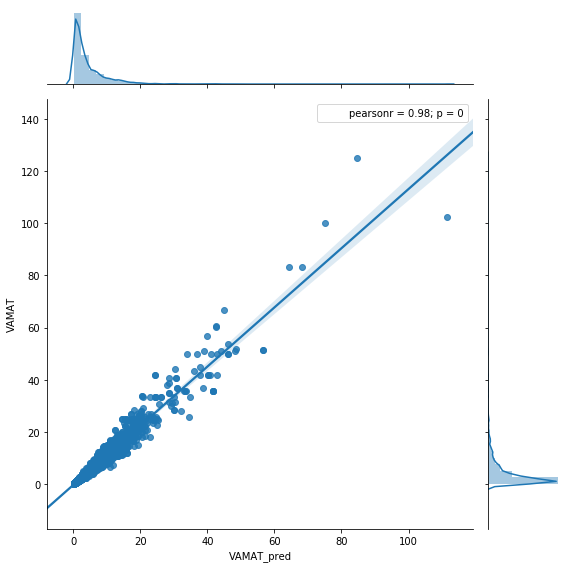

In [42]:
sns.jointplot(x='VAMAT_pred', y='VAMAT', data=dataset, kind='reg', size=8)

In [43]:
mean_squared_error(dataset['VAMAT'], dataset['VAMAT_pred'])

3.08046654116275

In [44]:
mean_absolute_percentage_error(dataset['VAMAT'], dataset['VAMAT_pred'])

11.004758519127043

# Per thickness

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y

In [46]:
class Regthick(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.thickness = []
    
    def fit(self, X, y):
        #X, y = check_X_y(X, y)
        self.thickness = X['thickness'].unique()
        parameters = {'alpha':np.logspace(-3,3,5),
                      'l1_ratio':np.linspace(0.01,1,5)
                        }
        for thickness in self.thickness:
            setattr(self, 'reg{:02d}'.format(int(thickness)),
                    GridSearchCV(ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False, fit_intercept=False),
                                 parameters, cv=3, n_jobs=-2, scoring='neg_mean_squared_error'))
            
            mask = X['thickness']==thickness
            #print(X.columns.values)
            df = X[mask]
            labels = y[mask]
            getattr(self, 'reg{:02d}'.format(int(thickness))).fit(df[['minimum_rectangle_area', 'bend_count']], labels)
    
    def predict(self, X, y=None):
        thickness = X[0]
        df = np.array(X[1:]).reshape(1, -1)
        return getattr(self, 'reg{:02d}'.format(int(thickness))).predict(df)
    
    def get_l1_ratio(self):
        toreturn = []
        for th in self.thickness:
            toreturn.append((th, getattr(self, 'reg{:02d}'.format(int(thickness))).estimator.l1_ratio))
        return toreturn
    
    def get_alpha(self):
        toreturn = []
        for th in self.thickness:
            toreturn.append((th, getattr(self, 'reg{:02d}'.format(int(thickness))).estimator.alpha))
        return toreturn
        
    def get_th_coefs(self):
        toreturn = []
        for th in self.thickness:
            temp = []
            estim = getattr(self, 'reg{:02d}'.format(int(th)))
            coeffs = estim.best_estimator_.coef_.copy()
            temp.append(th)
            temp.extend(coeffs.tolist())
            toreturn.append(temp)
        return np.array(toreturn)
    


In [47]:
regthick = Regthick()
regthick.fit(X_train[limitedset], y_train[target])

In [48]:
regthick.get_l1_ratio()

[(5.0, 1),
 (8.0, 1),
 (12.0, 1),
 (4.0, 1),
 (6.0, 1),
 (10.0, 1),
 (3.0, 1),
 (15.0, 1),
 (2.0, 1)]

In [49]:
regthick.get_alpha()

[(5.0, 0),
 (8.0, 0),
 (12.0, 0),
 (4.0, 0),
 (6.0, 0),
 (10.0, 0),
 (3.0, 0),
 (15.0, 0),
 (2.0, 0)]

In [50]:
#regthick.reg10.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))
regthick.predict([10.0, 123061.765625, 2])

array([13.94260903])

In [51]:
np.dot(regthick.reg10.best_estimator_.coef_, [123061.765625, 2])

13.94260903099423

In [52]:
#1.26214574e-05 * 123061.765625 + 6.96330034e-01*2
regthick.get_th_coefs()

array([[5.00000000e+00, 5.06829470e-05, 7.75819370e-01],
       [8.00000000e+00, 8.05158195e-05, 7.95511630e-01],
       [1.20000000e+01, 1.07964211e-04, 4.32202280e-01],
       [4.00000000e+00, 3.85920195e-05, 6.56602289e-01],
       [6.00000000e+00, 5.81423396e-05, 8.16917038e-01],
       [1.00000000e+01, 9.87294525e-05, 8.96394144e-01],
       [3.00000000e+00, 3.33501335e-05, 8.35804779e-01],
       [1.50000000e+01, 1.22726430e-04, 1.21510718e+00],
       [2.00000000e+00, 2.68541473e-05, 3.81410307e-01]])

In [53]:
df = pd.DataFrame(regthick.get_th_coefs())
df.columns=['thickness', 'K1', 'K2']
df.set_index('thickness', inplace=True)
df.sort_index()

,K1,K2
thickness,,
2.0,0.000027,0.381410
3.0,0.000033,0.835805
4.0,0.000039,0.656602
5.0,0.000051,0.775819
6.0,0.000058,0.816917
8.0,0.000081,0.795512
10.0,0.000099,0.896394
12.0,0.000108,0.432202
15.0,0.000123,1.215107


In [54]:
asmset = [[th, rect, bend] for th, rect, bend in zip(X_test.thickness.tolist(),
                                            X_test.minimum_rectangle_area.tolist(),
                                           X_test.bend_count.tolist(),)]

# Results comparison

In [55]:
prediction_s2 = np.array([regthick.predict(x)[0] for x in asmset])
prediction_s1 = regnostd.predict(X_test[limitedset])

In [56]:
resultset = pd.DataFrame({'target': y_test[target],
                          'pred_S1':prediction_s1,
                          'pred_S2':prediction_s2}, index=y_test.index)
resultset.head()

,pred_S1,pred_S2,target
COART,,,
L2514940,4.251108,0.779594,1.65
L8819170,4.061400,0.450232,1.26
L6705510,15.019633,13.183490,15.17
L3075990,6.757626,2.939439,3.84
L8420760,5.397876,2.770549,3.40


In [57]:
mean_squared_error(resultset['target'], resultset['pred_S1'])

23.115959819787417

In [58]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_S1'])

58.7256665749524

In [59]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_S2'])

21.27364865494777

In [60]:
mean_squared_error(resultset['target'], resultset['pred_S2'])

3.5908896588024626

In [61]:
resultset['MSE_s1'] = (resultset['target']-resultset['pred_S1'])**2
resultset['MSE_s2'] = (resultset['target']-resultset['pred_S2'])**2
resultset.head()

,pred_S1,pred_S2,target,MSE_s1,MSE_s2
COART,,,,,
L2514940,4.251108,0.779594,1.65,6.765764,0.757607
L8819170,4.061400,0.450232,1.26,7.847841,0.655724
L6705510,15.019633,13.183490,15.17,0.022610,3.946223
L3075990,6.757626,2.939439,3.84,8.512539,0.811011
L8420760,5.397876,2.770549,3.40,3.991507,0.396208


In [62]:
resultset['MSE_s2'].mean()

3.5908896588024626

In [63]:
#Comparison assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_S1,pred_S2,target,MSE_s1,MSE_s2,cut_length,num_closed_patterns,num_open_patterns,total_area,...,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,APPROX_BEND_COST
0,L2514940,4.251108,0.779594,1.65,6.765764,0.757607,443.695068,2,0,5409.296875,...,0.595280,0.60,1.05,1.65,0.000011,0.000008,0.000012,0,0.000062,1.050
1,L8819170,4.061400,0.450232,1.26,7.847841,0.655724,283.483337,1,0,5072.400879,...,0.343787,0.40,0.86,1.26,0.000010,0.000009,0.000010,0,0.000072,0.860
2,L6705510,15.019633,13.183490,15.17,0.022610,3.946223,4258.308594,11,1,117159.117188,...,6.802595,9.18,5.99,15.17,0.000015,0.000010,0.000026,3-5,0.000031,1.198
3,L3075990,6.757626,2.939439,3.84,8.512539,0.811011,798.948486,3,0,11440.706055,...,2.141611,1.68,2.16,3.84,0.000009,0.000006,0.000011,1-2,0.000072,1.080
4,L8420760,5.397876,2.770549,3.40,3.991507,0.396208,980.714661,2,0,17525.300781,...,2.115527,1.80,1.60,3.40,0.000009,0.000007,0.000010,0,0.000052,1.600


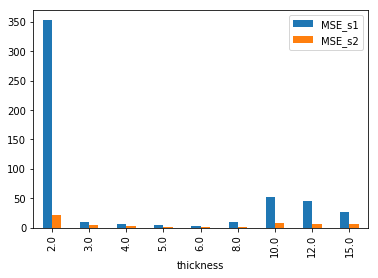

,MSE_s1,MSE_s2
thickness,,
2.0,352.159871,21.441204
3.0,9.621667,3.826324
4.0,6.518056,3.096066
5.0,3.967907,1.626477
6.0,2.732744,1.313739
8.0,9.769546,1.511980
10.0,52.540166,7.503129
12.0,45.765304,6.037479
15.0,26.879634,6.223456


In [64]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_s1', 'MSE_s2', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.show()
df

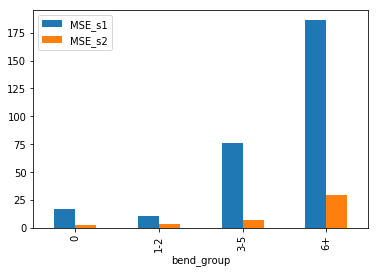

,MSE_s1,MSE_s2
bend_group,,
0,16.246506,2.350652
1-2,10.775456,3.003254
3-5,75.603229,7.127461
6+,186.189535,29.613263


In [65]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_s1', 'MSE_s2', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.show()
df

In [66]:
comparisonset.head()

,COART,pred_S1,pred_S2,target,MSE_s1,MSE_s2,cut_length,num_closed_patterns,num_open_patterns,total_area,...,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,APPROX_BEND_COST
0,L2514940,4.251108,0.779594,1.65,6.765764,0.757607,443.695068,2,0,5409.296875,...,0.595280,0.60,1.05,1.65,0.000011,0.000008,0.000012,0,0.000062,1.050
1,L8819170,4.061400,0.450232,1.26,7.847841,0.655724,283.483337,1,0,5072.400879,...,0.343787,0.40,0.86,1.26,0.000010,0.000009,0.000010,0,0.000072,0.860
2,L6705510,15.019633,13.183490,15.17,0.022610,3.946223,4258.308594,11,1,117159.117188,...,6.802595,9.18,5.99,15.17,0.000015,0.000010,0.000026,3-5,0.000031,1.198
3,L3075990,6.757626,2.939439,3.84,8.512539,0.811011,798.948486,3,0,11440.706055,...,2.141611,1.68,2.16,3.84,0.000009,0.000006,0.000011,1-2,0.000072,1.080
4,L8420760,5.397876,2.770549,3.40,3.991507,0.396208,980.714661,2,0,17525.300781,...,2.115527,1.80,1.60,3.40,0.000009,0.000007,0.000010,0,0.000052,1.600


In [67]:
#mean_absolute_percentage_error
comparisonset['MAPE_error_s1'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_S1']), axis=1)
comparisonset['MAPE_error_s2'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_S2']), axis=1)
comparisonset[[target, 'pred_S1', 'MAPE_error_s1', 'pred_S2', 'MAPE_error_s2']].head()

,VALTOT,pred_S1,MAPE_error_s1,pred_S2,MAPE_error_s2
0,1.65,4.251108,157.642921,0.779594,52.751896
1,1.26,4.061400,222.333323,0.450232,64.267270
2,15.17,15.019633,0.991212,13.183490,13.094992
3,3.84,6.757626,75.979834,2.939439,23.452122
4,3.40,5.397876,58.761049,2.770549,18.513254


In [68]:
mean_absolute_percentage_error(comparisonset['target'], comparisonset['pred_S2'])

21.27364865494777

In [69]:
comparisonset['MAPE_error_s2'].mean()

21.27364865494775

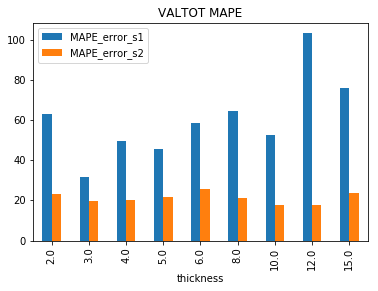

,MAPE_error_s1,MAPE_error_s2
thickness,,
2.0,62.804102,23.177461
3.0,31.409639,19.581699
4.0,49.436815,20.046665
5.0,45.400142,21.753054
6.0,58.584859,25.633437
8.0,64.285508,21.028089
10.0,52.432023,17.492086
12.0,103.137202,17.604824
15.0,76.143404,23.629841


In [70]:
df = comparisonset[['MAPE_error_s1', 'MAPE_error_s2', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
df

In [71]:
df = comparisonset[['MSE_s2', 'MAPE_error_s2', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])#.mean()
df.agg({'MSE_s2': ['mean', 'max'], 'MAPE_error_s2': ['mean', 'max'],'COART':['count'] })

MSE_s2             MAPE_error_s2            COART
                           mean         max          mean        max count
thickness bend_group                                                      
2.0       0            9.088890   27.252621     15.761836  40.095271     3
          1-2          1.480993    6.056401     32.608193  67.965067     9
          3-5         20.825769  171.565022     16.274545  54.594914    11
          6+          77.308360  234.088362     26.503054  62.962743     4
3.0       0            3.029506   22.317421     37.749823  71.807058    19
          1-2          1.213320   16.823868     14.657525  45.443334    44
          3-5          6.011764   41.915360     14.285444  64.823958    28
          6+          21.056164   45.430130     24.522812  39.469255     4
4.0       0            1.166465   27.743236     28.299369  78.230143    33
          1-2          1.079752   20.630744     18.847639  56.435024   109
          3-5          9.992427  220.320265     16.674115  50.664446    41
          6+           3.800232    3.800232     16.675949  16.675949     1
5.0       0            0.529566    2.663151     40.842102  81.150240    46
          1-2          1.283578   31.020758     16.784533  44.754637    82
          3-5          2.192042   25.550381      7.915968  19.804320    29
          6+          14.061324   60.587340      7.872661  18.173680     5
6.0       0            0.829468    6.231053     39.318721  86.076127   124
          1-2          0.883081    9.247561     16.598110  43.758875   142
          3-5          4.502448   38.338677     12.122638  56.565228    28
          6+          11.953509   26.444567     13.747994  27.079663     3
8.0       0            1.455255   46.847097     31.972137  77.719059   116
          1-2          1.498397   24.842104     12.366978  43.929908   125
          3-5          1.971872    7.498718     10.646387  30.943186    18
10.0      0            3.509205   73.588634     23.421031  88.651586    86
          1-2         11.095203  262.222032     12.247879  47.557939    77
          3-5         11.962308   59.198963     10.419727  26.606717    15
12.0      0            3.375305  136.283048     24.332032  82.626449    62
          1-2          9.094050  218.172426      9.880991  32.451880    54
15.0      0            7.329380   88.196515     26.836783  79.048667    44
          1-2          0.816714    3.272077      7.951455  16.399713     9

In [72]:
df.agg({'MSE_s2': ['mean', 'max'], 'MAPE_error_s2': ['mean', 'max'],'COART':['count'] }).loc[6]

MSE_s2            MAPE_error_s2            COART
                 mean        max          mean        max count
bend_group                                                     
0            0.829468   6.231053     39.318721  86.076127   124
1-2          0.883081   9.247561     16.598110  43.758875   142
3-5          4.502448  38.338677     12.122638  56.565228    28
6+          11.953509  26.444567     13.747994  27.079663     3

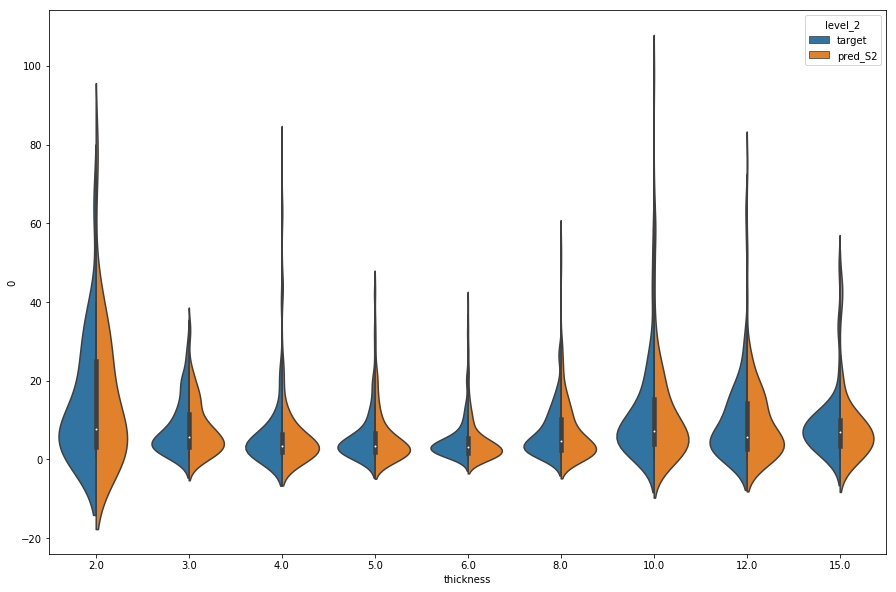

In [73]:
df=comparisonset[['target', 'pred_S2', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-20, 50)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)

plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


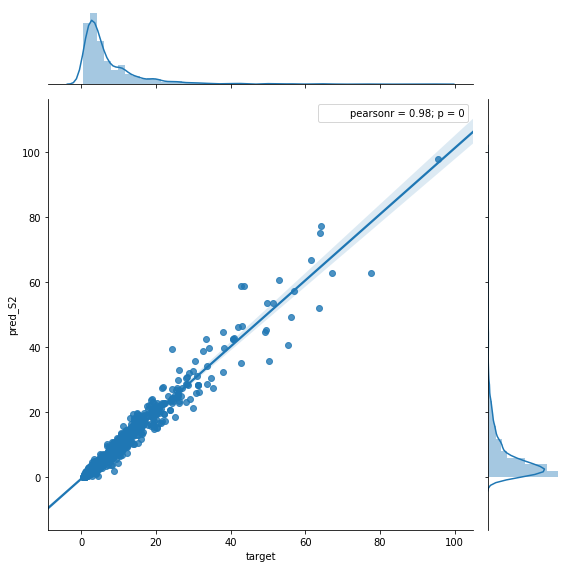

In [74]:
sns.jointplot(x='target', y='pred_S2', data=comparisonset, kind='reg', size=8)

In [75]:
df = comparisonset[['MSE_s2', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_s2'].nlargest(3)
worst
#worst.to_csv('worst_s0.csv')

thickness  COART   
2.0        L7067210    234.088362
           L2503310    171.565022
           L7011061     60.016608
3.0        L3103511     45.430130
           L8051761     41.915360
           L8039930     25.496432
4.0        L8838710    220.320265
           L8835250     44.680776
           L6704080     34.501588
5.0        L7065870     60.587340
           L8030260     31.020758
           L7065860     25.550381
6.0        L8833250     38.338677
           L6000540     32.836658
           L8835030     26.444567
8.0        L3119200     46.847097
           L3063420     24.842104
           L2502991     24.443151
10.0       L3059100    262.222032
           L3046960    237.568929
           L3027432    208.742858
12.0       L3063360    218.172426
           L3127960    136.283048
           L3020501    123.433779
15.0       L8833300     88.196515
           L7082620     47.405137
           L2512080     31.526226
Name: MSE_s2, dtype: float64

In [76]:
comparisonset['delta_s1'] = comparisonset['target'] - comparisonset['pred_S1']
comparisonset['delta_s2'] = comparisonset['target'] - comparisonset['pred_S2']

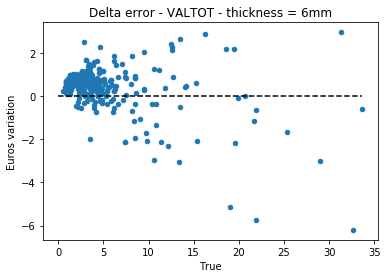

,delta_s2
count,297.000000
mean,0.417289
std,1.069326
min,-6.191823
25%,0.202734
50%,0.622661
75%,0.885195
max,2.958833


In [77]:
thickness = 6

df = comparisonset[comparisonset['thickness']==thickness]

df.plot.scatter('target', 'delta_s2')
plt.plot([0, df['target'].max()], [0, 0], color='k', linestyle='--')
plt.title('Delta error - {} - thickness = {}mm'.format(target, thickness))
plt.xlabel('True')
plt.ylabel('Euros variation')
plt.show()
df[['delta_s2']].describe()